In [1]:
import wandb
import torch
from diff_ts import GaussianDiffusion
from diff_ts import EpsilonTheta
import matplotlib.pyplot as plt


In [15]:
run = wandb.init(project="test_train_2")
artifact = run.use_artifact('fyp_a/test_train_2/model_batch64_lr0.0001_e500:v0')
artifact_dir = artifact.download()
model=GaussianDiffusion(EpsilonTheta([256]), input_size = 256)
model.load_state_dict(torch.load(f"{artifact_dir}/model_batch64_lr0.0001_e500.pth"))


wandb:   1 of 1 files downloaded.  


<All keys matched successfully>

In [16]:
model.eval()

GaussianDiffusion(
  (denoise_fn): EpsilonTheta(
    (input_projection): Conv1d(1, 8, kernel_size=(1,), stride=(1,), padding=(2,))
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=32, out_features=64, bias=True)
      (projection2): Linear(in_features=64, out_features=64, bias=True)
    )
    (residual_layers): ModuleList(
      (0-7): 8 x ResidualBlock(
        (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (diffusion_projection): Linear(in_features=64, out_features=8, bias=True)
        (output_projection): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
      )
    )
    (skip_projection): Conv1d(8, 8, kernel_size=(3,), stride=(1,))
    (output_projection): Conv1d(8, 1, kernel_size=(3,), stride=(1,))
  )
)

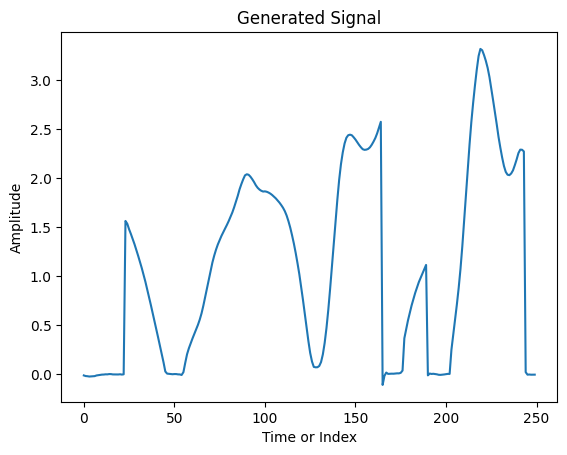

In [17]:
with torch.no_grad():  
    noise_shape = (10, 1, 250) 
    random_noise = torch.randn(noise_shape, device=model.betas.device)
    generated_signals = model.p_sample_loop(random_noise)
 
    plt.plot(generated_signals[5].squeeze().cpu().detach().numpy())
    plt.title("Generated Signal")
    plt.xlabel("Time or Index")
    plt.ylabel("Amplitude")
    plt.show()